In [1]:
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import  Conv2D ,MaxPool2D
from keras.layers import Activation,Dropout,Flatten, Dense
from keras import backend as k
import numpy as np
from keras.preprocessing import image
import tensorflow as tf
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import tqdm
from sklearn.utils import shuffle
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense, Activation, Conv2D, Flatten, BatchNormalization, Dropout, MaxPool2D
from keras.optimizers import Adam
from keras.callbacks import ReduceLROnPlateau, EarlyStopping
from keras.utils import np_utils
import pandas as pd
import tensorflow as tf
import time

Using TensorFlow backend.


# Setting up training and testing data

In [2]:
train_dir = "C:/Users/david/Desktop/train2"
test_dir= "C:/Users/david/Desktop/test1"

IMG_SIZE = (150, 150)

In [3]:
labels = []
img_path = []
path= 'C:/Users/david/Desktop/train2/'
for img in os.listdir(train_dir):
    img_path.append(os.path.join(path,img))
    
    if img.startswith("cat"):
        labels.append("cat")
    elif img.startswith("dog"):
        labels.append("dog")

In [4]:
df = pd.DataFrame({
    'image' : img_path,
    'class' : labels
})

<AxesSubplot:>

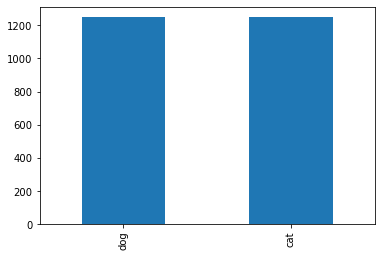

In [5]:
df['class'].value_counts().plot.bar()

In [6]:
# a training and validation data generator is used
train_datagen = ImageDataGenerator(validation_split = 0.2, rescale = 1. / 255)
train_generator = train_datagen.flow_from_dataframe(dataframe = df, 
                                                    x_col = 'image', 
                                                    y_col = 'class', 
                                                    batch_size = 64, 
                                                    seed = 11, 
                                                    class_mode = 'categorical', 
                                                    target_size = IMG_SIZE,
                                                    shuffle = True,
                                                    subset="training"
                                                   )

val_generator = train_datagen.flow_from_dataframe(dataframe = df, 
                                                    x_col = 'image', 
                                                    y_col = 'class', 
                                                    batch_size = 64, 
                                                    seed = 11, 
                                                    class_mode = 'categorical', 
                                                    target_size = IMG_SIZE,
                                                    shuffle = True,
                                                    subset="validation"
                                                   )

Found 2000 validated image filenames belonging to 2 classes.
Found 500 validated image filenames belonging to 2 classes.


In [7]:
# setting up training and validation steps
train_steps = train_generator.n // train_generator.batch_size
validation_steps = val_generator.n // val_generator.batch_size

# Building the model

In [8]:
from keras.applications import DenseNet201

base_model = DenseNet201(include_top=False, weights="imagenet",  input_shape=(150,150,3), pooling='avg' )

In [9]:
for layer in base_model.layers:
    layer.trainable = False

In [10]:
model = Sequential([
base_model,

Dense(512, activation='relu'),
Dropout(0.25),
BatchNormalization(),

Dense(512, activation='relu'),
Dropout(0.25),
BatchNormalization(),


# taylor the model's default softmax activation for 2 classes    
Dense(2, activation='softmax')])


model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
densenet201 (Model)          (None, 1920)              18321984  
_________________________________________________________________
dense_1 (Dense)              (None, 512)               983552    
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 512)               2048      
_________________________________________________________________
dense_2 (Dense)              (None, 512)               262656    
_________________________________________________________________
dropout_2 (Dropout)          (None, 512)               0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 512)              

In [11]:
model.compile(optimizer='Nadam',loss='binary_crossentropy',metrics=["accuracy"])

# add early stopping and learning rate reduction to optimizer model performance
es = EarlyStopping(monitor='val_loss',mode='min', verbose=1,patience=10)

lr = ReduceLROnPlateau(monitor='val_accuracy', patience=3,verbose=1, factor=0.25, min_lr=0.0001)

epochs = 10

In [13]:
# save the weights of the best model

from keras.callbacks import ModelCheckpoint

checkpoint = ModelCheckpoint("best_model_nadam_densenet2.hdf5", monitor='val_accuracy', verbose=1,
    save_best_only=True, mode='max', period=1, save_weights_only=True)

In [14]:
history = model.fit_generator(generator=train_generator,
                    steps_per_epoch= 10, epochs=epochs, callbacks = [es, lr, checkpoint],
                    validation_data = val_generator,validation_steps = validation_steps, max_queue_size=100, verbose=1)

Epoch 1/10
10/10 [==============================] - 108s 11s/step - loss: 0.4332 - accuracy: 0.8212 - val_loss: 0.1152 - val_accuracy: 0.9665

Epoch 00001: val_accuracy improved from -inf to 0.96652, saving model to best_model_nadam_densenet2.hdf5
Epoch 2/10
10/10 [==============================] - 111s 11s/step - loss: 0.2533 - accuracy: 0.9000 - val_loss: 0.2128 - val_accuracy: 0.9427

Epoch 00002: val_accuracy did not improve from 0.96652
Epoch 3/10
10/10 [==============================] - 110s 11s/step - loss: 0.1936 - accuracy: 0.9375 - val_loss: 0.4351 - val_accuracy: 0.9266

Epoch 00003: val_accuracy did not improve from 0.96652
Epoch 4/10
10/10 [==============================] - 107s 11s/step - loss: 0.0897 - accuracy: 0.9636 - val_loss: 0.1804 - val_accuracy: 0.9450

Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 00004: val_accuracy did not improve from 0.96652
Epoch 5/10
10/10 [==============================] - 110s 11s/step - loss: 0.1

# Inspecting results

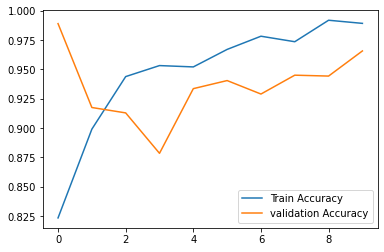

In [16]:
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

epochs = range(len(train_acc))


plt.plot(epochs, train_acc, label = 'Train Accuracy')
plt.plot(epochs, val_acc, label = 'validation Accuracy')
plt.legend(loc=0)

plt.show()

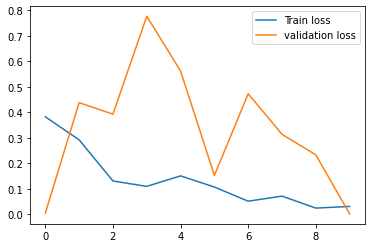

In [17]:
train_loss = history.history['loss']
val_loss = history.history['val_loss']




plt.plot(epochs, train_loss, label = 'Train loss')
plt.plot(epochs, val_loss, label = 'validation loss')
plt.legend(loc=0)
plt.show()

# Classify unlabelled data

In [25]:
# use the weights of the model with the best validation accuracy to make predictions
model.load_weights("best_model_rms_densenet.hdf5")

In [27]:
test_img_path = []

test_path = 'C:/Users/david/Desktop/test1/'

for img in os.listdir(test_path):
    test_img_path.append(os.path.join(test_path, img))
    
df_test = pd.DataFrame({'image_path': test_img_path})

In [28]:
test_datagen = ImageDataGenerator(rescale = 1./ 255)
test_generator = test_datagen.flow_from_dataframe(dataframe = df_test,
                                                 x_col = 'image_path',
                                                 y_col = None,
                                                 batch_size = 50,
                                                 seed = 11,
                                                 target_size = IMG_SIZE,
                                                   class_mode=None,)





test_steps = test_generator.n // test_generator.batch_size

predictions = model.predict(test_generator,steps = test_steps, verbose= 1)

Found 400 validated image filenames.
8/8 [==============================] - 73s 9s/step


In [29]:
print(type(predictions))
print(predictions[:10])

<class 'numpy.ndarray'>
[[6.6722292e-03 9.9332774e-01]
 [7.5905053e-03 9.9240947e-01]
 [9.2564356e-03 9.9074358e-01]
 [1.0000000e+00 8.1565744e-21]
 [1.0000000e+00 7.6730497e-26]
 [1.0000000e+00 3.1560332e-28]
 [1.0000000e+00 1.7953336e-28]
 [1.0000000e+00 6.4997495e-18]
 [1.0000000e+00 1.6539628e-22]
 [1.0000000e+00 2.8835384e-13]]


In [30]:
predictions = np.argmax(predictions,axis=1)

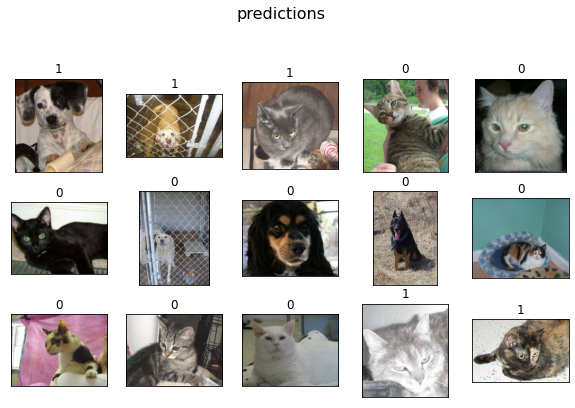

In [33]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt

fig = plt.figure(figsize = (10,10))
fig.suptitle("predictions", fontsize = 16)

for i, img in enumerate(df_test.image_path[15:30]):
  plt.subplot(5, 5, i + 1)
  img = mpimg.imread(img)
  plt.imshow(img)
  plt.title(str(predictions[i]))
  plt.xticks([])
  plt.yticks([])

In [32]:
df_test["label"]=predictions
df_test.to_csv("submission.csv",index=False)